In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
#data_cat = df_pretraite= pd.read_csv('C:\\Users\\actou\\Documents\\IODAA\\AZOTE\\fil_rouge-main\\data_pretraitee\\data_categorielle.csv',sep = ';')
data_cat = df_pretraite= pd.read_csv('C:\\Users\\actou\\Documents\\IODAA\\AZOTE\\fil_rouge-main\\data_pretraitee\\data_categorielle_picutil_23light.csv',sep = ';')

In [3]:
data_cat.columns

Index(['Bande', 'CP', 'Peuplement', 'Travail_sol_J60', 'Ajout_phyto_30J',
       'Ajout_ferti_30J', 'year', 'Temp_quali', 'Pluie_quali', 'Saison',
       'soil_h1_quali', 'soil_h2_quali', 'N2O_quali'],
      dtype='object')

In [4]:
#target = data_cat['Pic_J182']
target = data_cat['N2O_quali']

In [5]:
data_cat.head()

,Bande,CP,Peuplement,Travail_sol_J60,Ajout_phyto_30J,Ajout_ferti_30J,year,Temp_quali,Pluie_quali,Saison,soil_h1_quali,soil_h2_quali,N2O_quali
0,acs,ble,ble,False,0,1,2018,moyenne,elevee,hiver,elevee,moyenne,elevee
1,acs,ble,ble,False,0,1,2018,moyenne,elevee,printemps,elevee,elevee,elevee
2,pn,ble,ble,False,0,1,2018,moyenne,elevee,printemps,elevee,elevee,elevee
3,bio,ble,ble,False,0,1,2018,moyenne,elevee,printemps,elevee,elevee,moyenne
4,elev,ble,ble,False,0,1,2018,moyenne,elevee,printemps,elevee,elevee,elevee


In [7]:
data_cat["Travail_sol_J60"] = data_cat["Travail_sol_J60"].astype("float64")

In [6]:
data_fullcat = data_cat.drop(["Pic_J182","N2O","soilH_h1","soilH_h2","N2O_J182","N2O_quali","Date"], axis=1)

In [7]:
data_fullcat.columns

Index(['Bande', 'CP', 'Peuplement', 'Travail_sol_J60', 'Ajout_phyto_30J',
       'Ajout_ferti_30J', 'year', 'Temp_quali', 'Pluie_quali', 'Saison',
       'soil_h1_quali', 'soil_h2_quali'],
      dtype='object')

RFE

In [ ]:
rf = RandomForestClassifier(n_estimators=200)
rfe = RFE(rf, n_features_to_select=1)
rfe.fit_transform(dummy_data, target)

In [107]:
dummy_data.loc[:,rfe.get_support()]

,Temp_moyenne_5J
0,10.54
1,10.54
2,10.54
3,10.54
4,10.54
...,...
368,18.00
369,19.70
370,19.70
371,15.26


<BarContainer object of 54 artists>

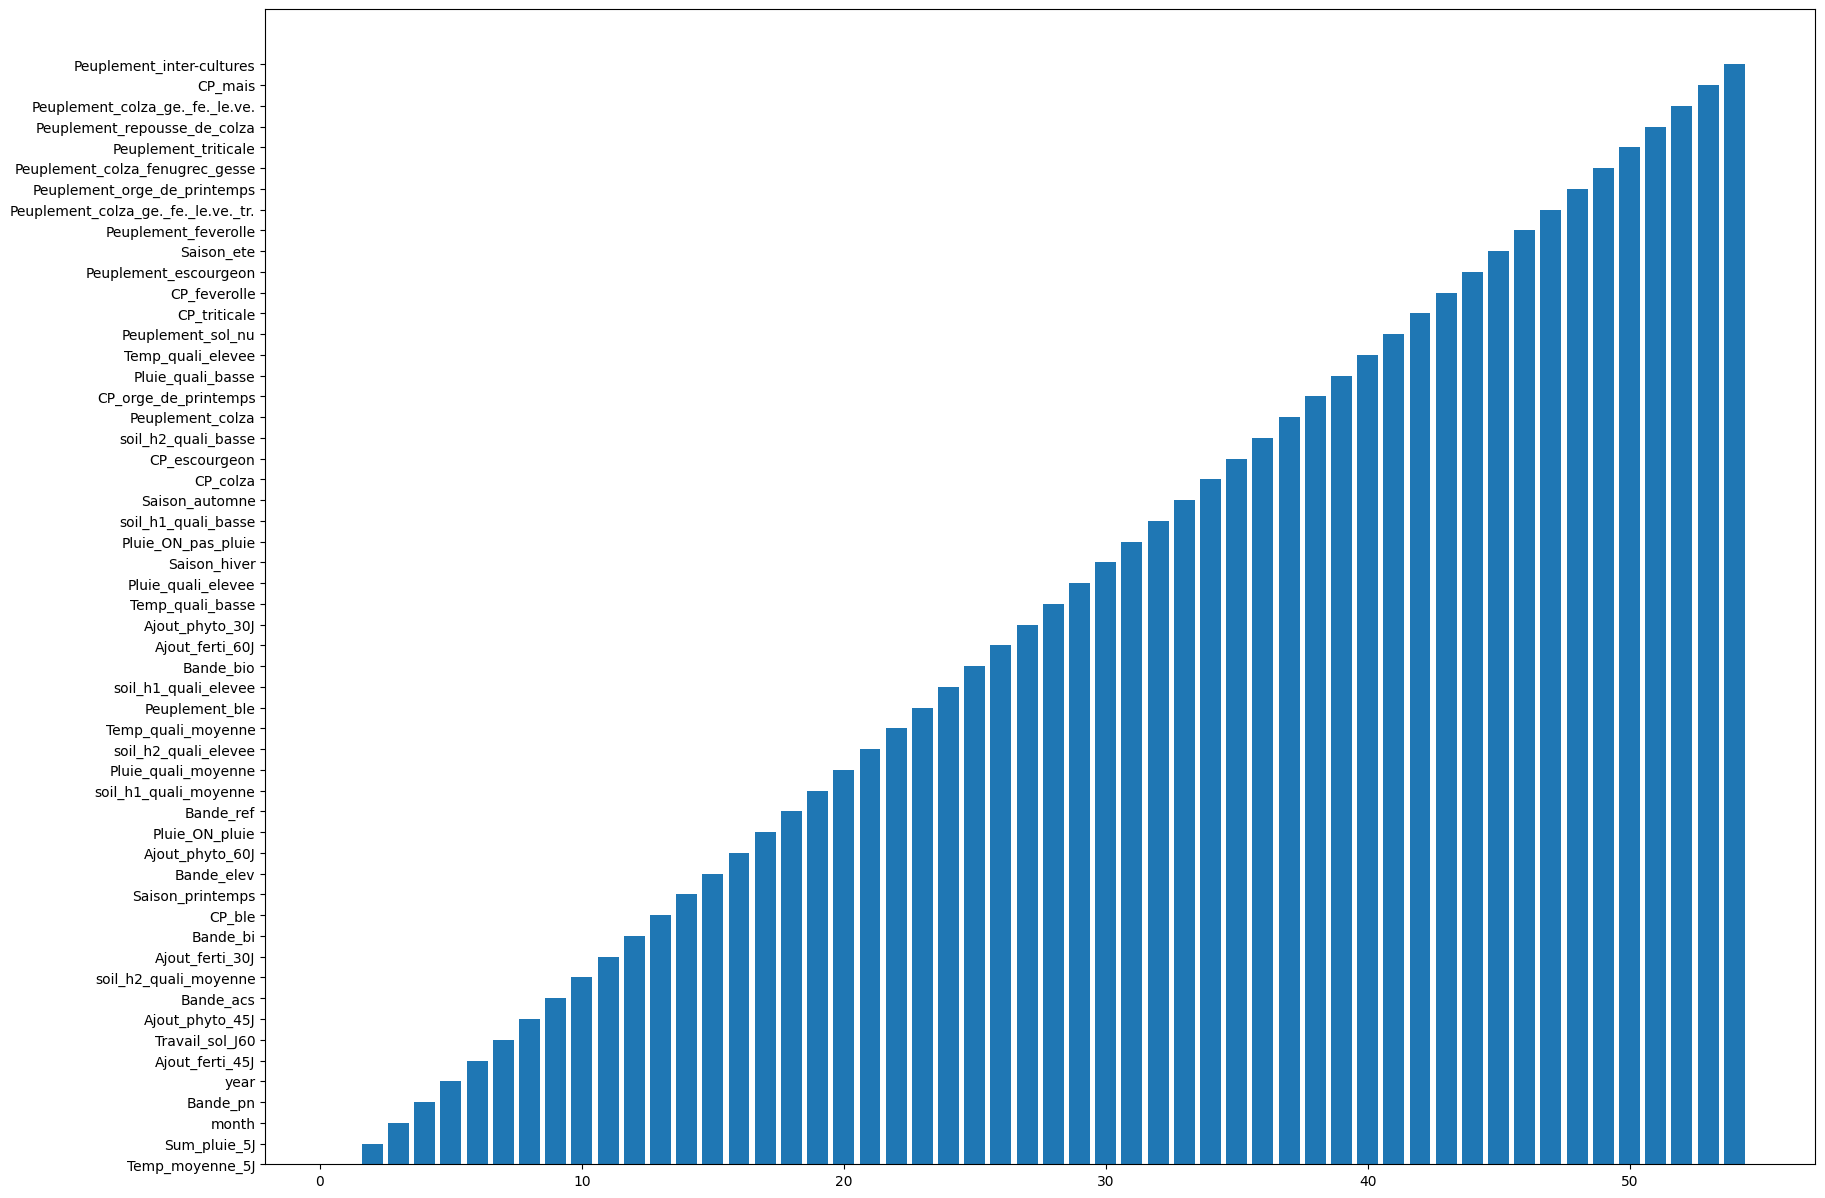

In [108]:
rfe_ranking = pd.DataFrame({"feature":dummy_data.columns, "rank":rfe.ranking_})
rfe_ranking = rfe_ranking.sort_values("rank")

plt.figure(figsize=(20,15))
plt.bar(rfe_ranking["rank"], rfe_ranking["feature"])

In [82]:
rfe_ranking.to_csv("rfe_feature_selection.csv", sep=";")

### RandomForestClassifier

Optimal n_estimators: 400


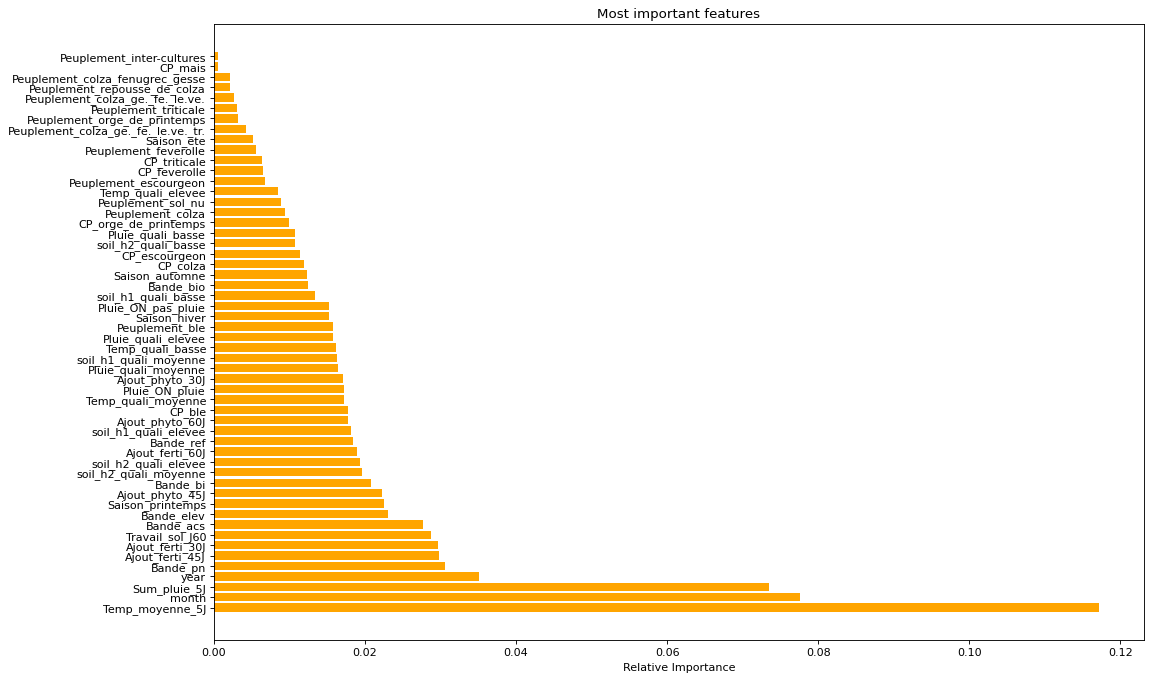

In [65]:
n_estimators_range = range(100, 1000, 100)
cv_scores = []

for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_estimators)
    scores = cross_val_score(rf, dummy_data, target, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_n_estimators = n_estimators_range[np.argmax(cv_scores)]
print('Optimal n_estimators:', optimal_n_estimators)

rf = RandomForestClassifier(n_estimators=optimal_n_estimators)
rf.fit(dummy_data, target)

data_rfc = pd.DataFrame(list(zip(dummy_data.columns, rf.feature_importances_)), columns=['feature','importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(15, 10), dpi=80)
plt.barh(y=data_rfc['feature'], width=data_rfc['importance'], color='orange')
plt.title('Most important features')
plt.xlabel('Relative Importance')
plt.show()


XGBoost avec feature importance

<AxesSubplot:>

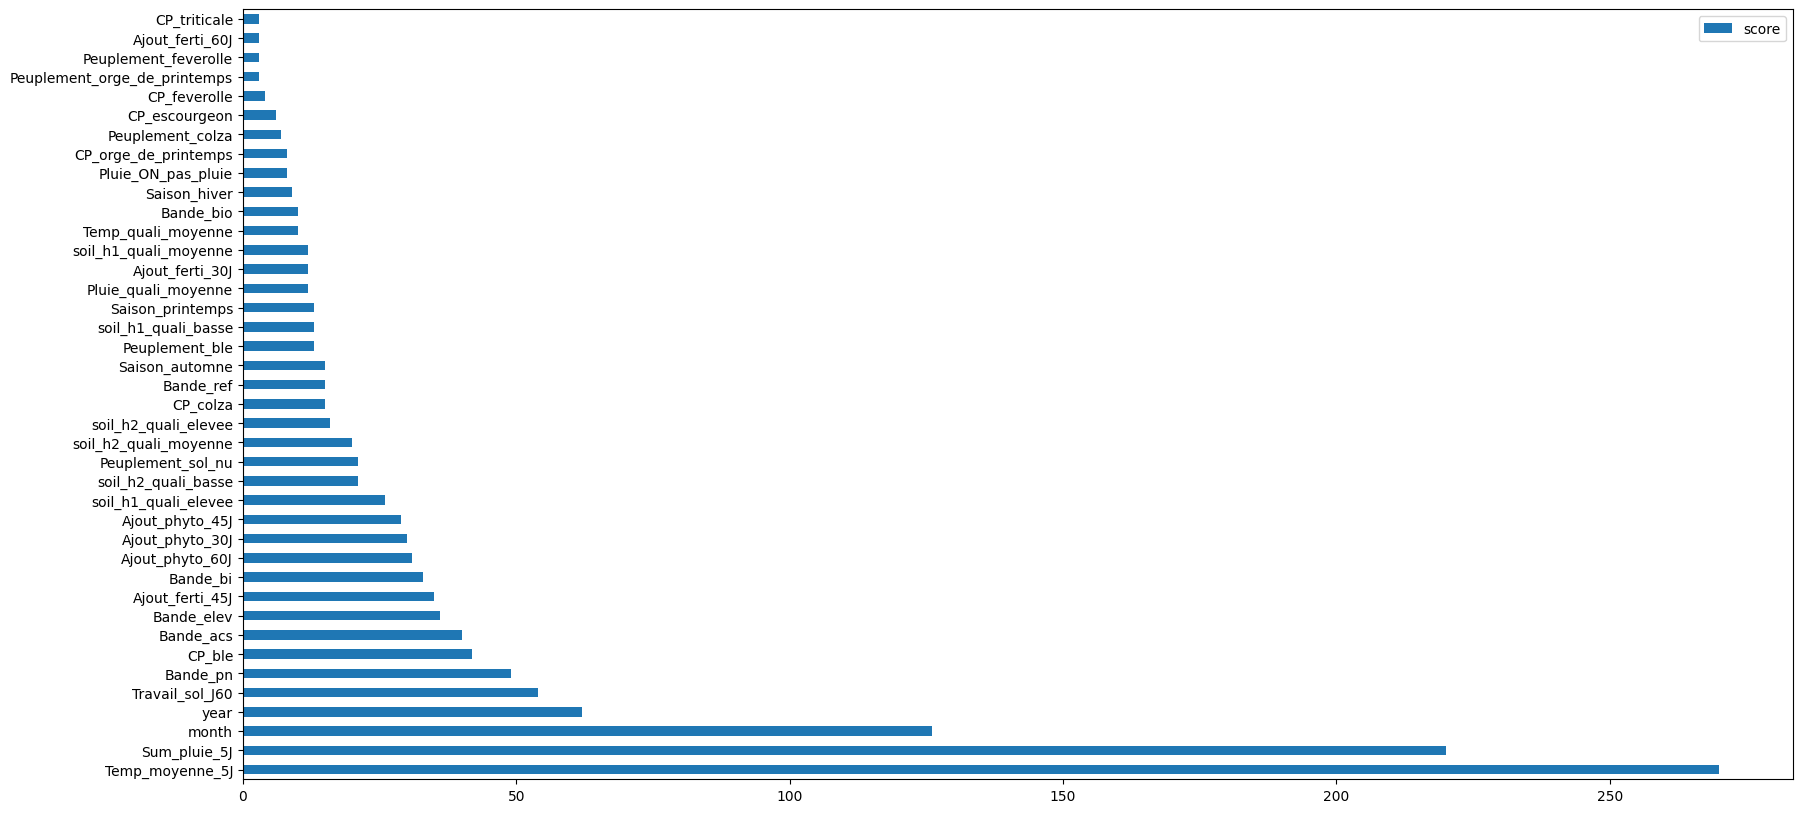

In [64]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(dummy_data, target)
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data_xgb = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_xgb.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

In [69]:
xgboost_fs = pd.DataFrame({"feature":keys, "weight":values}, index=[i for i in range(len(values))])

In [70]:
xgboost_fs.to_csv("xgboost_features_selected.csv", sep=";")

---------------------------------------


Resulats de la selection de varaibles

In [68]:
data_rfc.head()

,feature,importance
7,Temp_moyenne_5J,0.117238
10,month,0.077596
8,Sum_pluie_5J,0.073507
9,year,0.035143
15,Bande_pn,0.030594


In [71]:
xgboost_fs.head()

,feature,weight
0,Travail_sol_J60,54.0
1,Ajout_phyto_30J,30.0
2,Ajout_phyto_45J,29.0
3,Ajout_phyto_60J,31.0
4,Ajout_ferti_30J,12.0


In [109]:
rfe_ranking.head()

,feature,rank
7,Temp_moyenne_5J,1
8,Sum_pluie_5J,2
10,month,3
15,Bande_pn,4
9,year,5


In [110]:
df_merge = pd.merge(data_rfc, xgboost_fs, on="feature").merge(rfe_ranking, on="feature").rename(columns={"importance":"RFC_importance", "weight":"XGBoost_weight", "rank":"RFE_ranking"})
df_merge.head()

,feature,RFC_importance,XGBoost_weight,RFE_ranking
0,Temp_moyenne_5J,0.117238,270.0,1
1,month,0.077596,126.0,3
2,Sum_pluie_5J,0.073507,220.0,2
3,year,0.035143,62.0,5
4,Bande_pn,0.030594,49.0,4


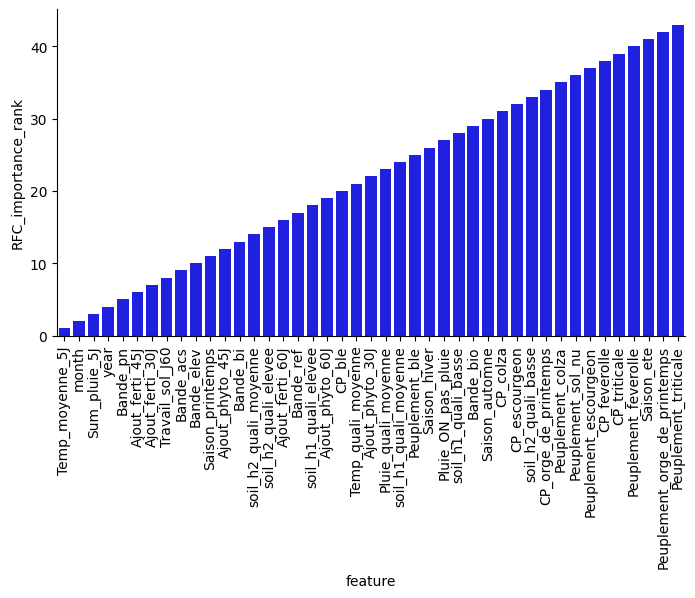

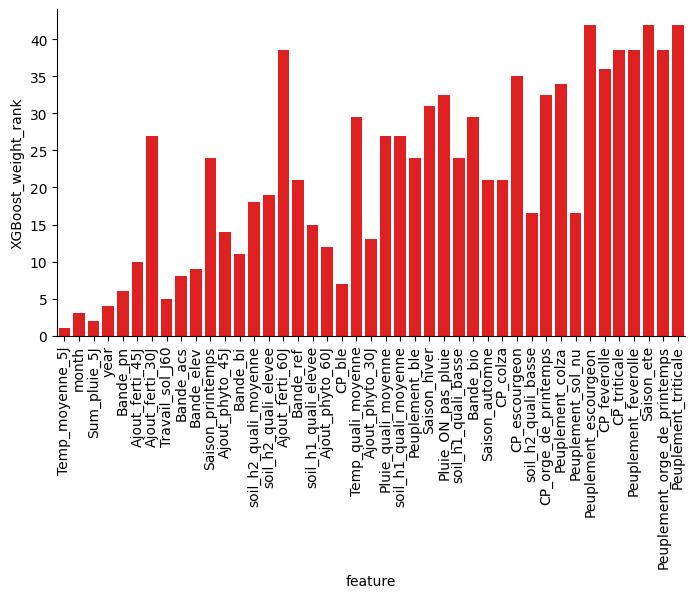

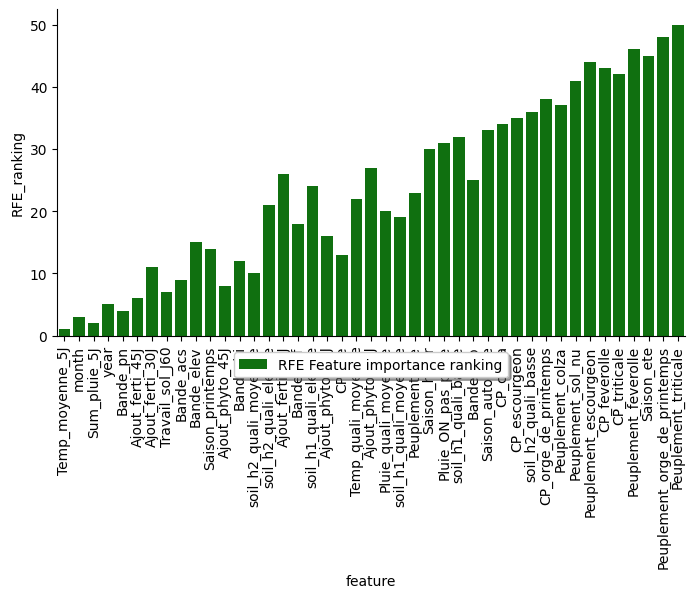

In [111]:
df_rank = df_merge.copy()

df_rank["RFC_importance_rank"] = df_rank["RFC_importance"].rank(ascending=False)
df_rank["XGBoost_weight_rank"] = df_rank["XGBoost_weight"].rank(ascending=False)
df_rank.sort_values(by=["RFC_importance_rank", "XGBoost_weight_rank", "RFE_ranking"], inplace=True)
df_rank.head()

g = sns.catplot(x="feature", y="RFC_importance_rank", kind="bar", data=df_rank, color="b", height=4, aspect=2, label="Random Forest Feature importance ranking")
g.set_xticklabels(rotation=90)

g2 = sns.catplot(x="feature", y="XGBoost_weight_rank", kind="bar", data=df_rank, color="r", height=4, aspect=2, label="XGBoost Feature importance ranking")
g2.set_xticklabels(rotation=90)

g3 = sns.catplot(x="feature", y="RFE_ranking", kind="bar", data=df_rank, color="g", height=4, aspect=2, label="RFE Feature importance ranking")
g3.set_xticklabels(rotation=90)

# add legend

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03), fancybox=True, shadow=True, ncol=3)

# show the graph
plt.show()

In [135]:
df_rank.head()

,feature,RFC_importance,XGBoost_weight,RFE_ranking,RFC_importance_rank,XGBoost_weight_rank
0,Temp_moyenne_5J,0.117238,270.0,1,1.0,1.0
1,month,0.077596,126.0,3,2.0,3.0
2,Sum_pluie_5J,0.073507,220.0,2,3.0,2.0
3,year,0.035143,62.0,5,4.0,4.0
4,Bande_pn,0.030594,49.0,4,5.0,6.0


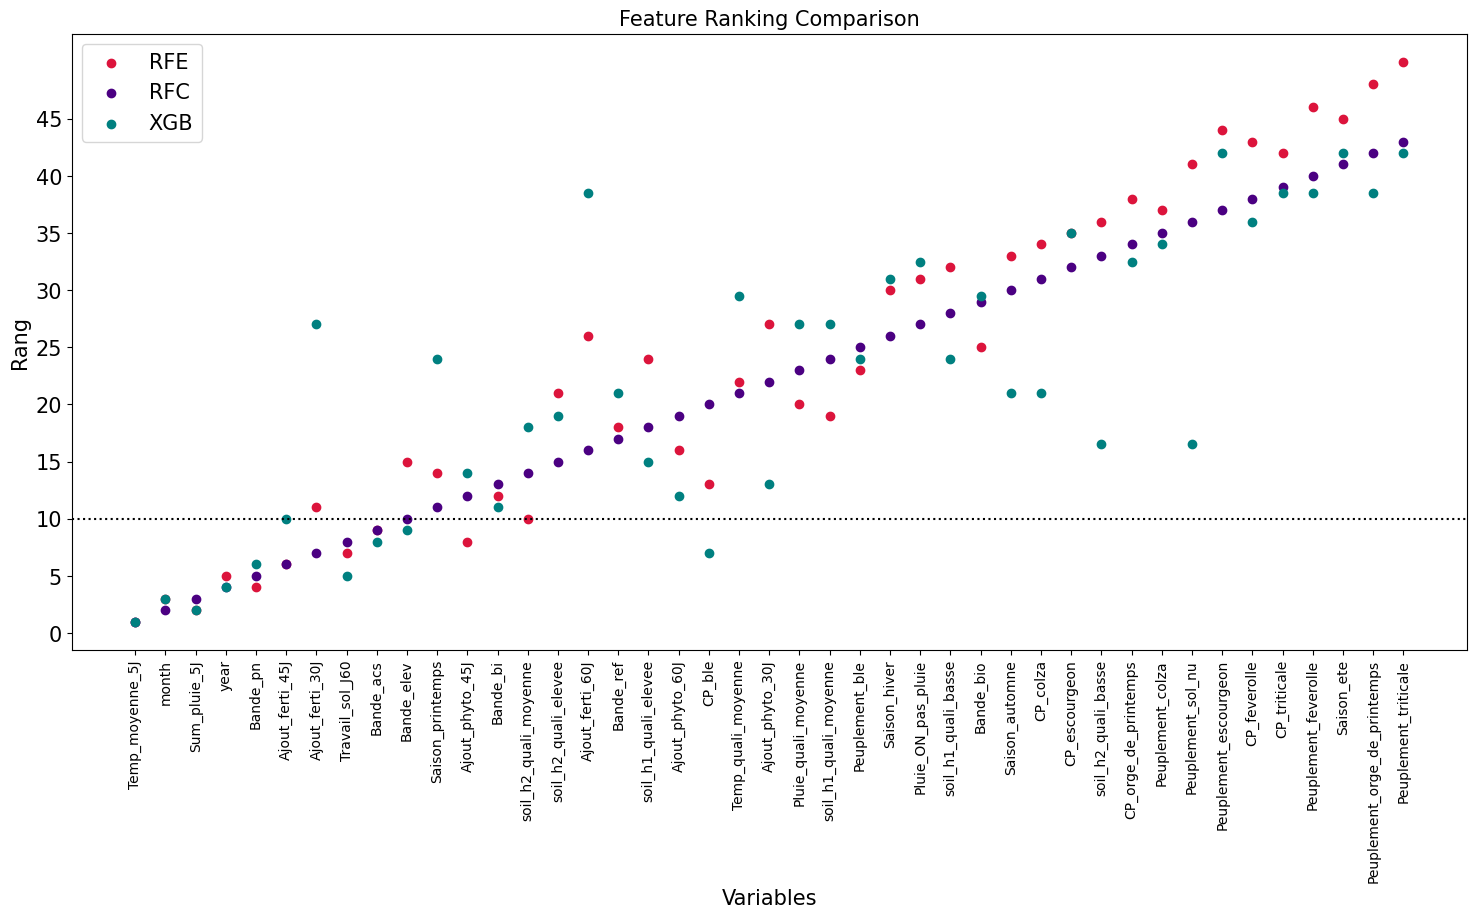

In [199]:

# scatter plot 
liste = df_rank["feature"]
plt.figure(figsize=(18, 8))
plt.scatter(x="feature", y="RFE_ranking", data=df_rank,c='crimson', label='RFE')
plt.scatter(x="feature", y="RFC_importance_rank" ,data=df_rank,c='indigo', label='RFC')
plt.scatter(x="feature", y="XGBoost_weight_rank", data=df_rank,c='teal', label='XGB')

plt.title('Feature Ranking Comparison', fontsize=15)
plt.xlabel('Variables',fontsize=15)
plt.ylabel('Rang',fontsize=15)
plt.xticks(liste, rotation=90, fontsize=10)
plt.yticks(np.arange(0, 50, 5),fontsize=15)
plt.axhline(y=10, color='black', linestyle='dotted')
#plt.axvline(x=10, color='black', linestyle='dotted')
plt.legend(fontsize=15)
#plt.legend(loc=(5, 45),fancybox=True, shadow=True, ncol=3,bbox_to_anchor=(0.5, -0.03))
plt.show()


In [153]:

df_rank_top10 = df_rank[["RFE_ranking","RFC_importance_rank" ,"XGBoost_weight_rank"]].head(10)
df_rank_top10


,RFE_ranking,RFC_importance_rank,XGBoost_weight_rank
0,1,1.0,1.0
1,3,2.0,3.0
2,2,3.0,2.0
3,5,4.0,4.0
4,4,5.0,6.0
5,6,6.0,10.0
6,11,7.0,27.0
7,7,8.0,5.0
8,9,9.0,8.0
9,15,10.0,9.0


Plot intersection des mots 

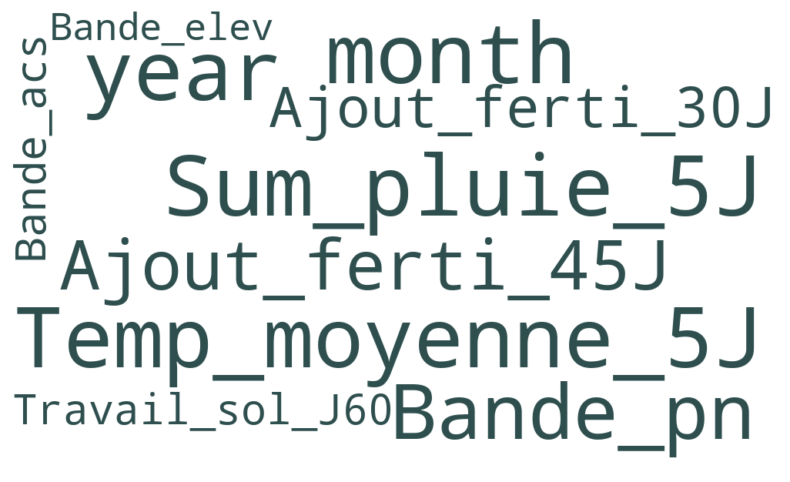

In [203]:
RFE_liste = df_rank.loc[0:9,"feature"].tolist()
RFC_liste = df_rank.loc[0:9,"feature"].tolist()
XGBoost_liste = df_rank.loc[0:9,"feature"].tolist()

intersection = []
for i in RFE_liste:
    if i in RFC_liste and i in XGBoost_liste:
        intersection.append(i)

wordcloud = WordCloud(background_color="white",width=1000, height=600)

RFE_liste_words = ' '.join(RFE_liste)
RFC_liste_words = ' '.join(RFC_liste)
XGBoost_liste_words = ' '.join(XGBoost_liste)
intersection_words = ' '.join(intersection)


wordcloud.generate_from_text(RFE_liste_words)
wordcloud.recolor(color_func=lambda *args, **kwargs: 'green')
wordcloud.generate_from_text(RFC_liste_words)
wordcloud.recolor(color_func=lambda *args, **kwargs: 'red')
wordcloud.generate_from_text(XGBoost_liste_words)
wordcloud.recolor(color_func=lambda *args, **kwargs: 'blue')
wordcloud.generate_from_text(intersection_words)
wordcloud.recolor(color_func=lambda *args, **kwargs: 'darkslategray')

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")

plt.show()

In [163]:
intersection

['Temp_moyenne_5J',
 'month',
 'Sum_pluie_5J',
 'year',
 'Bande_pn',
 'Ajout_ferti_45J',
 'Ajout_ferti_30J',
 'Travail_sol_J60',
 'Bande_acs',
 'Bande_elev']

Diapo = plot score SCORING [0 - 1] 



